In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

Final Counts for the Last Step:
{'110': 153, '000': 20, '010': 428, '100': 399}
[0.02  0.399 0.428 0.153 0.    0.    0.    0.   ]
Hash Value: 00000000000000000000000101000000000010100000000000100000000000000000000000000000000000000000000000000000


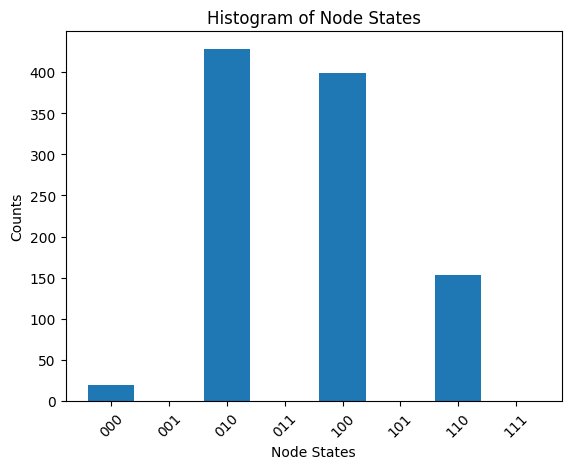

In [30]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import U3Gate

# Define the message and ensure it has an even number of bits
original_message = "00110011010101010101010011000111"
if len(original_message) % 2 != 0:
    original_message += "0"
    
steps = 2  # Number of steps, corresponding to the length of the message
n = 3  # Number of quantum positions

qpos = QuantumRegister(n, 'qc')
qcoin = QuantumRegister(1, 'qanc')
cpos = ClassicalRegister(n, 'cr')
circuit = QuantumCircuit(qpos, qcoin, cpos)
    

initial_angle = np.arcsin(np.sin(np.pi/6))  # Adjust the angle θ as needed
initial_state = U3Gate(initial_angle, 0, 0)
circuit.append(initial_state, [qcoin])


# Define the coin operators based on the description
def coin_operator_C1():
    return np.array([[np.cos(np.pi/8), np.sin(np.pi/8)],
                     [np.sin(np.pi/8), -np.cos(np.pi/8)]])

def coin_operator_C2():
    return np.array([[np.cos(np.pi/4), np.sin(np.pi/4)],
                     [np.sin(np.pi/4), -np.cos(np.pi/4)]])

def coin_operator_C3():
    return np.array([[np.cos(np.pi/3), np.sin(np.pi/3)],
                     [np.sin(np.pi/3), -np.cos(np.pi/3)]])

def coin_operator_C4():
    return np.array([[np.cos(3*np.pi/7), np.sin(3*np.pi/7)],
                     [np.sin(3*np.pi/7), -np.cos(3*np.pi/7)]])

def apply_coin_operator(circuit, qcoin, message_bits):
    if message_bits == "00":
        circuit.unitary(coin_operator_C1(), [qcoin])
    elif message_bits == "01":
        circuit.unitary(coin_operator_C2(), [qcoin])
    elif message_bits == "10":
        circuit.unitary(coin_operator_C3(), [qcoin])
    elif message_bits == "11":
        circuit.unitary(coin_operator_C4(), [qcoin])

def counts_to_prob_1d(counts):
    # Convert histogram counts to probability vector of size 1 x 2^n
    states = list(counts.keys())
    state_counts = list(counts.values())
    nshots = sum(state_counts)
    # Convert binary to integer index, reversing order as consistent w qiskit convention
    states_x = [int(s[::-1],2) for s in states]
    # Create array of probability values
    probabilities = np.zeros(2**n)
    probabilities[states_x] = state_counts
    probabilities /= nshots
    return probabilities

def increment_gate(circuit, qpos, qcoin):
    n = len(qpos)
    for i in range(n):
        circuit.mct([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')

def decrement_gate(circuit, qpos, qcoin):
    n = len(qpos)
    circuit.x(qcoin[0])
    for i in range(n):
        if i + 1 < n:
            circuit.x(qpos[i + 1:])
        circuit.mct([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')
        if i + 1 < n:
            circuit.x(qpos[i + 1:])

def step(circuit, qpos, qcoin, message_bits):
    apply_coin_operator(circuit, qcoin, message_bits)
    circuit.barrier()
    increment_gate(circuit, qpos, qcoin)
    circuit.barrier()
    decrement_gate(circuit, qpos, qcoin)
    circuit.barrier()

def run_quantum_coin_walk(message, steps):
    simulatorType = 'quantum'
    simulator = Aer.get_backend('qasm_simulator')

    for i in range(len(message) // 2):
        message_bits = message[i * 2:i * 2 + 2]  # Extract the message bits for this step
        step(circuit, qpos, qcoin, message_bits)
    circuit.measure(qpos, cpos)

    job = execute(circuit, simulator, shots=1000)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

seed = 12
random.seed(seed)
np.random.seed(seed)

counts = run_quantum_coin_walk(original_message, steps)

# Reverse the order of node states in the counts dictionary
reversed_counts = {state[::-1]: count for state, count in counts.items()}

print("Final Counts for the Last Step:")
print(reversed_counts)

probabilities = counts_to_prob_1d(reversed_counts)
print(probabilities)

hash_value = ""
scaling_factor = 10^ 4

# Calculate the binary strings for each probability
binary_strings = [format(int(prob * scaling_factor), '013b') for prob in probabilities]

# Concatenate the binary strings to obtain the hash value
hash_value = "".join(binary_strings)

print("Hash Value:", hash_value)


import matplotlib.pyplot as plt

def plot_histogram(counts):
    # Create a list of all possible node states from "000" to "111"
    all_states = [format(i, '03b') for i in range(8)]

    # Initialize counts for all states with 0 if not present in 'counts'
    state_counts = [counts[state] if state in counts else 0 for state in all_states]

    plt.bar(all_states, state_counts)
    plt.xlabel('Node States')
    plt.ylabel('Counts')
    plt.title('Histogram of Node States')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.show()

# Assuming you already have the 'counts' dictionary
plot_histogram(reversed_counts)

In [40]:

hash_value = ""
scaling_factor = 10^4

# Calculate the binary strings for each probability
binary_strings = [format(int(prob * scaling_factor), '013b') for prob in probabilities]

# Concatenate the binary strings to obtain the hash value
hash_value = "".join(binary_strings)
print(hash_value)



00000000000000000000000101000000000010100000000000100000000000000000000000000000000000000000000000000000


In [21]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.tools.monitor import job_monitor

# Define the message and ensure it has an even number of bits
original_message = "001101100100110011001110101010101011101001"
if len(original_message) % 2 != 0:
    original_message += "0"
    
conditions = [
    original_message,
    original_message.replace("0", "1", 1),  # Change a 0 to 1
    original_message.replace("1", "0", 1),  # Change a 1 to 0
    original_message[1:],  # Delete the first bit
    original_message[:4] + "1" + original_message[4:],  # Insert a bit randomly
]
# Define the coin operators based on the description
def coin_operator_C1():
    return np.array([[np.cos(np.pi/8), np.sin(np.pi/8)],
                     [np.sin(np.pi/8), -np.cos(np.pi/8)]])

def coin_operator_C2():
    return np.array([[np.cos(np.pi/4), np.sin(np.pi/4)],
                     [np.sin(np.pi/4), -np.cos(np.pi/4)]])

def coin_operator_C3():
    return np.array([[np.cos(np.pi/3), np.sin(np.pi/3)],
                     [np.sin(np.pi/3), -np.cos(np.pi/3)]])

def coin_operator_C4():
    return np.array([[np.cos(3*np.pi/7), np.sin(3*np.pi/7)],
                     [np.sin(3*np.pi/7), -np.cos(3*np.pi/7)]])

def apply_coin_operator(circuit, qcoin, message_bits):
    if message_bits == "00":
        circuit.unitary(coin_operator_C1(), [qcoin])
    elif message_bits == "01":
        circuit.unitary(coin_operator_C2(), [qcoin])
    elif message_bits == "10":
        circuit.unitary(coin_operator_C3(), [qcoin])
    elif message_bits == "11":
        circuit.unitary(coin_operator_C4(), [qcoin])

def counts_to_prob_1d(counts):
    # Convert histogram counts to a probability vector of size 1 x 2^n
    states = list(counts.keys())
    state_counts = list(counts.values())
    nshots = sum(state_counts)
    # Convert binary to an integer index, reversing order as consistent with qiskit convention
    states_x = [int(s[::-1], 2) for s in states]
    # Create an array of probability values
    probabilities = np.zeros(2 ** n)
    probabilities[states_x] = state_counts
    probabilities /= nshots
    return probabilities

def increment_gate(circuit, qpos, qcoin):
    n = len(qpos)
    for i in range(n):
        circuit.mct([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')

def decrement_gate(circuit, qpos, qcoin):
    n = len(qpos)
    circuit.x(qcoin[0])
    for i in range(n):
        if i + 1 < n:
            circuit.x(qpos[i + 1:])
        circuit.mct([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')
        if i + 1 < n:
            circuit.x(qpos[i + 1:])

def step(circuit, qpos, qcoin, message_bits):
    apply_coin_operator(circuit, qcoin, message_bits)
    circuit.barrier()
    increment_gate(circuit, qpos, qcoin)
    circuit.barrier()
    decrement_gate(circuit, qpos, qcoin)
    circuit.barrier()
    
def run_quantum_coin_walk(message, steps):
    simulatorType = 'quantum'
    simulator = Aer.get_backend('qasm_simulator')

    qpos = QuantumRegister(n, 'qc')
    qcoin = QuantumRegister(1, 'qanc')
    cpos = ClassicalRegister(n, 'cr')
    circuit = QuantumCircuit(qpos, qcoin, cpos)
    
    for i in range(len(message)//2):
        message_bits = message[i * 2:i * 2 + 2]  # Extract the message bits for this step
        step(circuit, qpos, qcoin, message_bits)
    circuit.measure(qpos, cpos)

    job = execute(circuit, simulator, shots=1000)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

seed = 12
random.seed(seed)
np.random.seed(seed)

steps = 2  # Number of steps, corresponding to the length of the message
n = 3  # Number of quantum positions

for i, condition_message in enumerate(conditions, start=1):
    counts = run_quantum_coin_walk(condition_message, steps)

    # Reverse the order of node states in the counts dictionary
    reversed_counts = {state[::-1]: count for state, count in counts.items()}

    print("Final Counts for the Last Step:")
    print(reversed_counts)

    probabilities = counts_to_prob_1d(reversed_counts)
    print(probabilities)

    hash_value = ""
    scaling_factor = 10**4

    # Calculate the binary strings for each probability
    binary_strings = [format(int(prob * scaling_factor), '013b') for prob in probabilities]

    # Concatenate the binary strings to obtain the hash value
    hash_value = "".join(binary_strings)


    print(f"Condition {i} (Binary): {hash_value}")

Final Counts for the Last Step:
{'101': 116, '011': 67, '001': 737, '111': 80}
[0.    0.    0.    0.    0.737 0.116 0.067 0.08 ]
Condition 1 (Binary): 00000000000000000000000000000000000000000000000000001110011001010001001000100000010100111100001100100000
Final Counts for the Last Step:
{'011': 25, '101': 154, '001': 615, '111': 206}
[0.    0.    0.    0.    0.615 0.154 0.025 0.206]
Condition 2 (Binary): 00000000000000000000000000000000000000000000000000001100000000110001100000010000000111110100100000001100
Final Counts for the Last Step:
{'111': 94, '011': 74, '001': 411, '101': 421}
[0.    0.    0.    0.    0.411 0.421 0.074 0.094]
Condition 3 (Binary): 00000000000000000000000000000000000000000000000000001000000001110100000111001000010111001000001110101100
Final Counts for the Last Step:
{'100': 51, '010': 5, '000': 77, '110': 867}
[0.077 0.051 0.005 0.867 0.    0.    0.    0.   ]
Condition 4 (Binary): 0001100000010000011111110100000001100101000011101111000000000000000000000000000000

In [26]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.tools.monitor import job_monitor

# Define the message and ensure it has an even number of bits
original_message = "00"
if len(original_message) % 2 != 0:
    original_message += "0"

# Define the coin operators based on the description
def coin_operator_C1():
    return np.array([[np.cos(np.pi/8), np.sin(np.pi/8)],
                     [np.sin(np.pi/8), -np.cos(np.pi/8)]])

def coin_operator_C2():
    return np.array([[np.cos(np.pi/4), np.sin(np.pi/4)],
                     [np.sin(np.pi/4), -np.cos(np.pi/4)]])

def coin_operator_C3():
    return np.array([[np.cos(np.pi/3), np.sin(np.pi/3)],
                     [np.sin(np.pi/3), -np.cos(np.pi/3)]])

def coin_operator_C4():
    return np.array([[np.cos(3*np.pi/7), np.sin(3*np.pi/7)],
                     [np.sin(3*np.pi/7), -np.cos(3*np.pi/7)]])

def apply_coin_operator(circuit, qcoin, message_bits):
    if message_bits == "00":
        circuit.unitary(coin_operator_C1(), [qcoin])
    elif message_bits == "01":
        circuit.unitary(coin_operator_C2(), [qcoin])
    elif message_bits == "10":
        circuit.unitary(coin_operator_C3(), [qcoin])
    elif message_bits == "11":
        circuit.unitary(coin_operator_C4(), [qcoin])

def counts_to_prob_1d(counts):
    states = list(counts.keys())
    state_counts = list(counts.values())
    nshots = sum(state_counts)
    states_x = [int(s[::-1], 2) for s in states]
    probabilities = np.zeros(2 ** n)
    probabilities[states_x] = state_counts
    probabilities /= nshots
    return probabilities

def increment_gate(circuit, qpos, qcoin):
    n = len(qpos)
    for i in range(n):
        circuit.mct([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')

def decrement_gate(circuit, qpos, qcoin):
    n = len(qpos)
    circuit.x(qcoin[0])
    for i in range(n):
        if i + 1 < n:
            circuit.x(qpos[i + 1:])
        circuit.mct([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')
        if i + 1 < n:
            circuit.x(qpos[i + 1:])

def step(circuit, qpos, qcoin, message_bits):
    apply_coin_operator(circuit, qcoin, message_bits)
    circuit.barrier()
    increment_gate(circuit, qpos, qcoin)
    circuit.barrier()
    decrement_gate(circuit, qpos, qcoin)
    circuit.barrier()

# Function to perform the quantum coin walk and generate hash values
def run_quantum_coin_walk(message, steps, n):
    simulator = Aer.get_backend('qasm_simulator')
    qpos = QuantumRegister(n, 'qc')
    qcoin = QuantumRegister(1, 'qanc')
    cpos = ClassicalRegister(n, 'cr')
    circuit = QuantumCircuit(qpos, qcoin, cpos)

    for i in range(len(message)//2):
        message_bits = message[i * 2:i * 2 + 2]
        step(circuit, qpos, qcoin, message_bits)

    circuit.measure(qpos, cpos)

    job = execute(circuit, simulator, shots=1000)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

def generate_hash_from_counts(counts):
    probabilities = counts_to_prob_1d(counts)
    hash_value = ""
    scaling_factor = 10**4

    # Calculate the binary strings for each probability
    binary_strings = [format(int(prob * scaling_factor), '013b') for prob in probabilities]

    # Concatenate the binary strings to obtain the hash value
    hash_value = "".join(binary_strings)
    return hash_value

# Function to calculate the number of changed bits and added zero bits
def calculate_changed_bits(hash_value1, hash_value2):
    changed_bits = sum(bit1 != bit2 for bit1, bit2 in zip(hash_value1, hash_value2))
    # Compare the lengths of hash_value1 and hash_value2
    len1 = len(hash_value1)
    len2 = len(hash_value2)

      # Initialize a counter for added zero bits
    added_zero_bits = 0

    # Determine the longer and shorter hash values
    longer_hash = hash_value1 if len1 > len2 else hash_value2
    shorter_hash = hash_value2 if len1 > len2 else hash_value1

    # Count the added zero bits
    for i in range(len(shorter_hash), len(longer_hash)):
        if longer_hash[i] == '0':
            added_zero_bits += 1

    return changed_bits, added_zero_bits

# Perform the diffusion and confusion tests
def perform_diffusion_confusion_tests(N, message, steps, n):
    original_counts = run_quantum_coin_walk(message, steps, n)
    # Reverse the order of node states in the counts dictionaries
    o_reversed_counts = {state[::-1]: count for state, count in original_counts.items()}
    original_hash = generate_hash_from_counts(o_reversed_counts)


    BBN_list = []
    AAN_list = []
    TAB_list = []
    PT_list = []
    TN_list = []
    PN_list = []

    for i in range(N):
        modified_message = modify_message_randomly(message)
        modified_counts = run_quantum_coin_walk(modified_message, steps, n)
        # Reverse the order of node states in the counts dictionary
        m_reversed_counts = {state[::-1]: count for state, count in modified_counts.items()}
        modified_hash = generate_hash_from_counts(m_reversed_counts)

        changed_bits, added_zero_bits = calculate_changed_bits(original_hash, modified_hash)

        BBN = changed_bits
        AAN = added_zero_bits
        TAB = BBN + AAN
        PT = (TAB / 104) * 100
        TN = (TAB - BBN)
        PN = (PT - (BBN / 104 ) * 100)

        BBN_list.append(BBN)
        AAN_list.append(AAN)
        TAB_list.append(TAB)
        PT_list.append(PT)
        TN_list.append(TN)
        PN_list.append(PN)

    return BBN_list, AAN_list, TAB_list, PT_list, TN_list, PN_list

# Function to modify the message by changing a random bit
def modify_message_randomly(message):
    index_to_modify = random.randint(0, len(message) - 1)
    modified_message = message[:index_to_modify] + ('0' if message[index_to_modify] == '1' else '1') + message[index_to_modify + 1:]
    return modified_message

# Define your parameters
seed = 12
random.seed(seed)
np.random.seed(seed)

steps = 2
n = 3
original_message = "001101100100110011001110101010101011101001"

N_values = [1024]

# Perform diffusion and confusion tests for different values of N
for N in N_values:
    BBN_list, AAN_list, TAB_list, PT_list, TN_list, PN_list = perform_diffusion_confusion_tests(N, original_message, steps, n)

    print(f"N = {N}")
    print("Mean BBN:", np.mean(BBN_list))
    print("Mean AAN:", np.mean(AAN_list))
    print("Mean TAB:", np.mean(TAB_list))
    print("Mean PT (%):", np.mean(PT_list))
    print("Mean ΔT:", np.mean(TN_list))
    print("Mean ΔP:", np.mean(PN_list))


N = 1024
Mean BBN: 21.4501953125
Mean AAN: 0.1220703125
Mean TAB: 21.572265625
Mean PT (%): 20.74256310096154
Mean ΔT: 0.1220703125
Mean ΔP: 0.11737530048076922
